# Analysis

Let's look at one particular example of the CORD dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


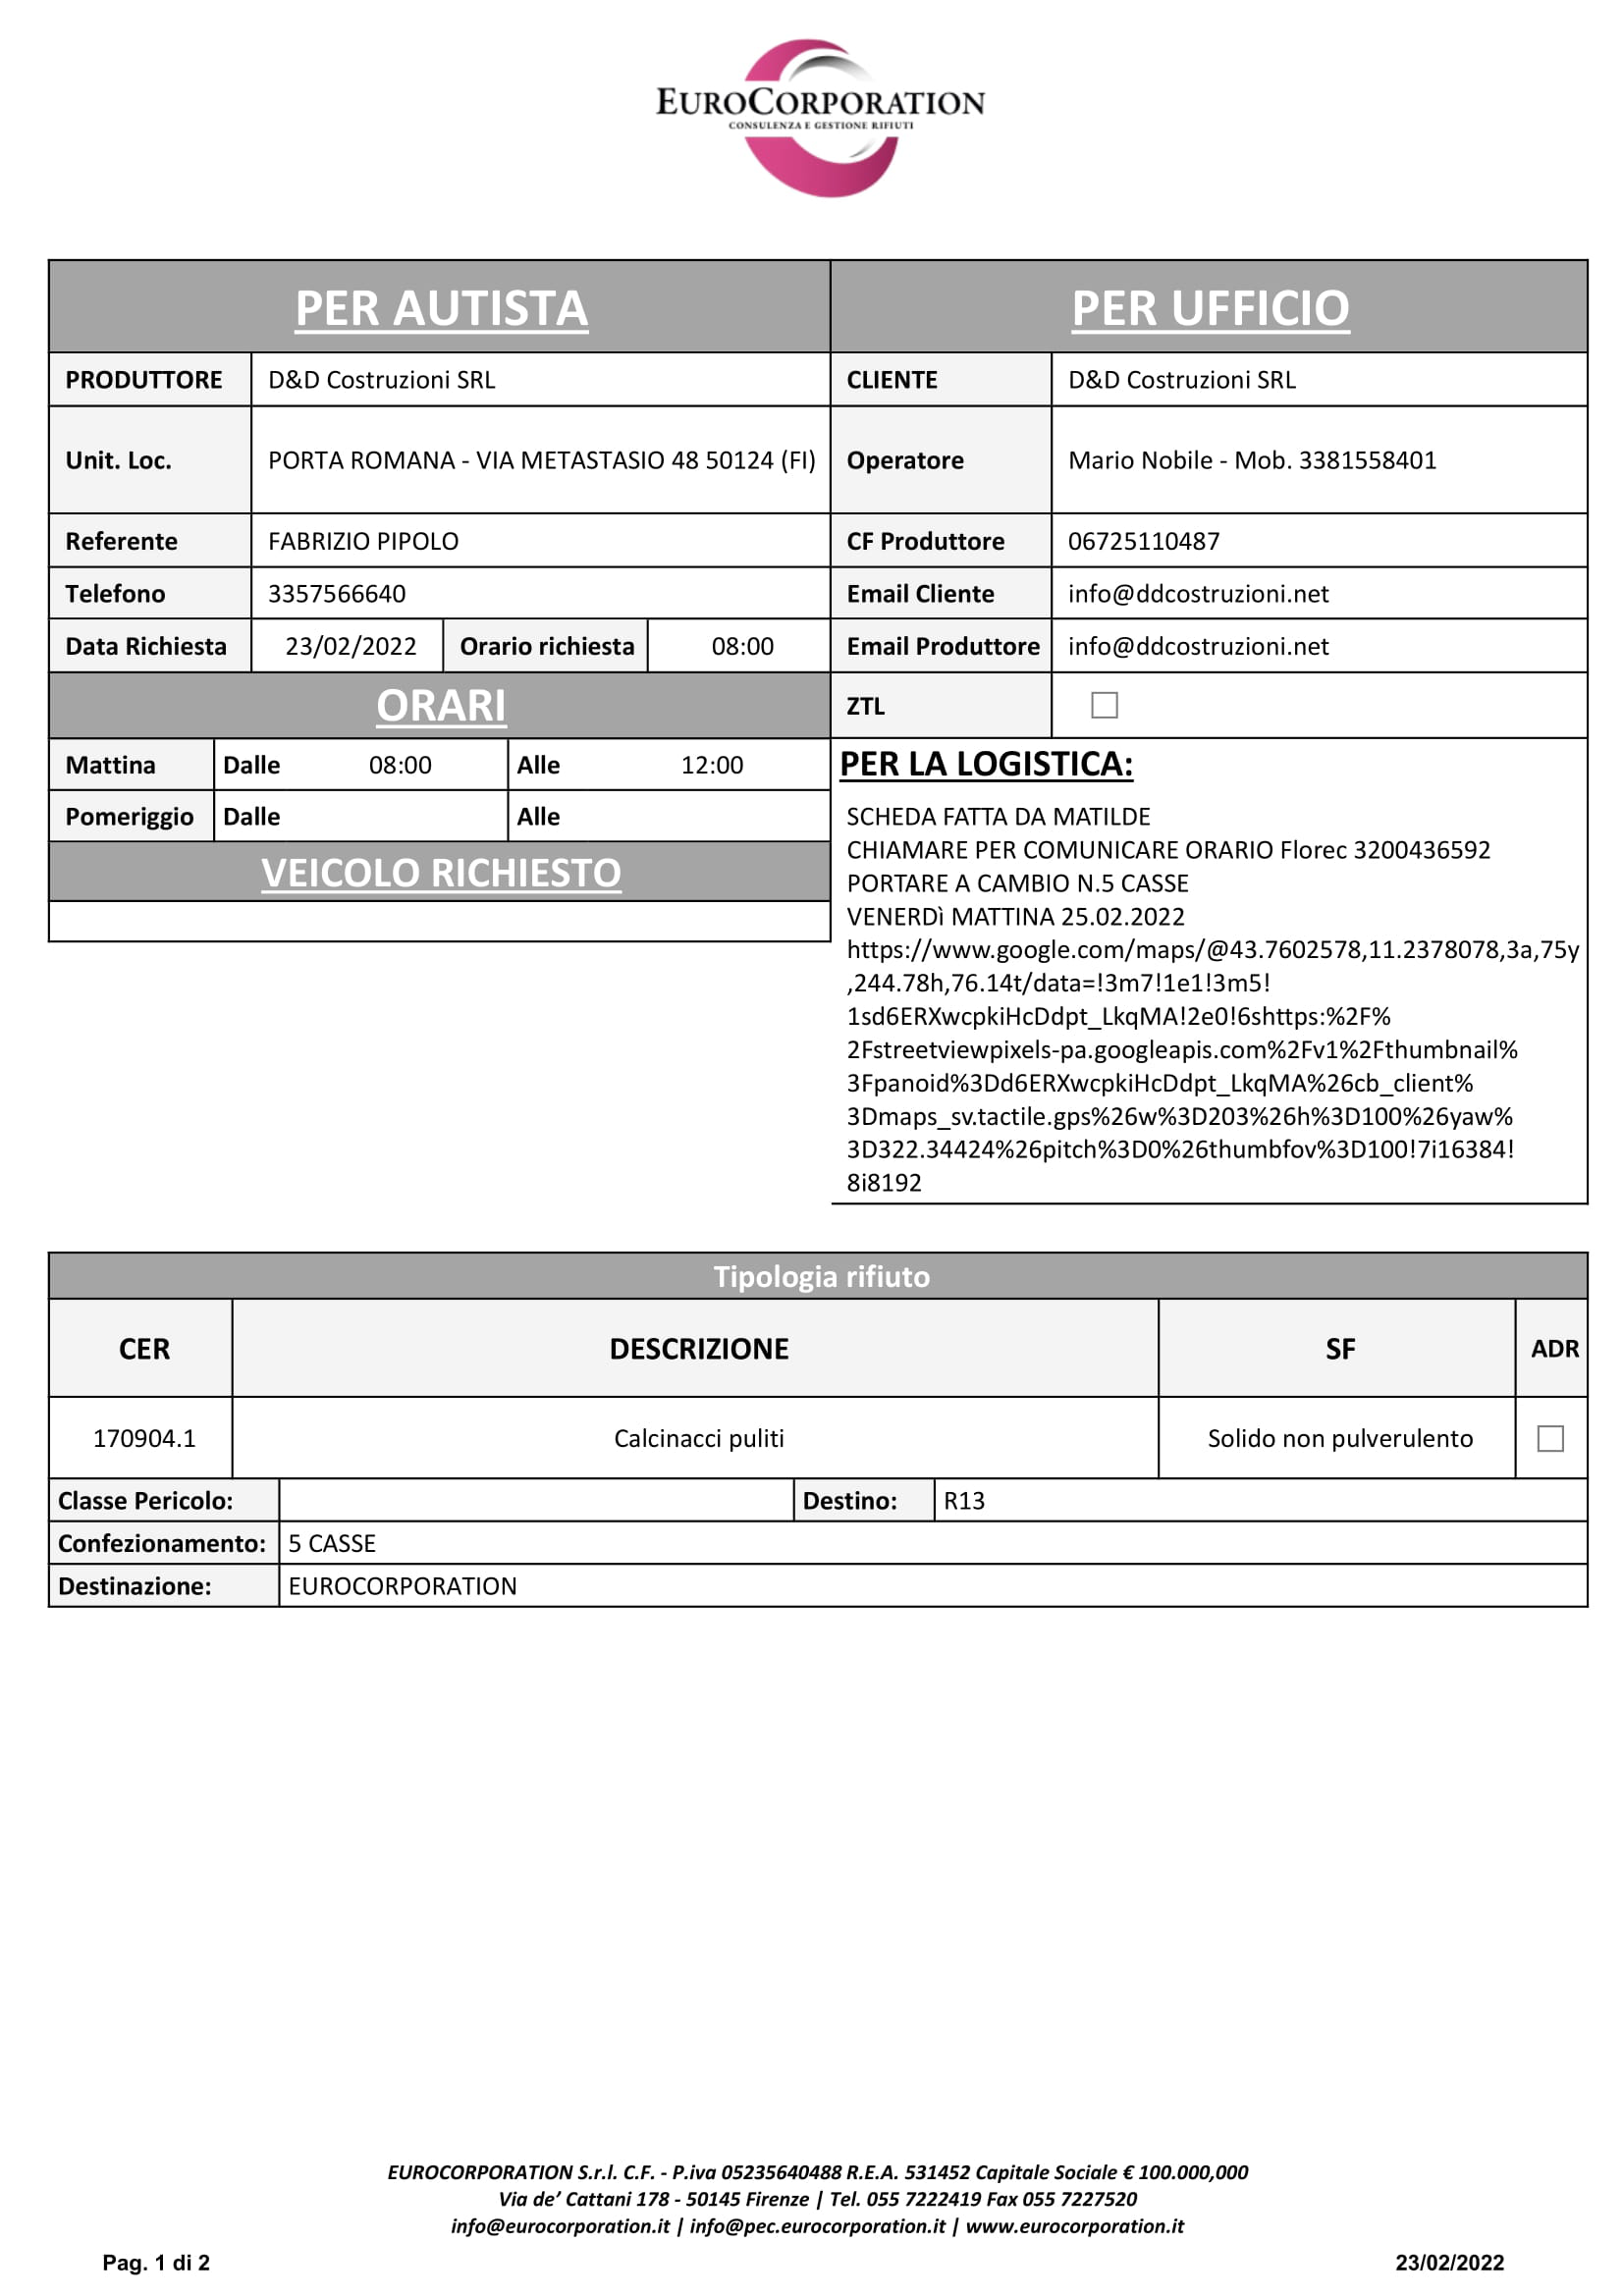

In [3]:
from PIL import Image

image = Image.open('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/images/train/1.jpg')
image

Let's read in the corresponding OCR annotations.

In [4]:
import json

with open('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/JSON/train/1.json') as json_file:
    data = json.load(json_file)

In [5]:
data.keys()

dict_keys(['dontcare', 'valid_line', 'meta', 'roi', 'repeating_symbol'])

In [6]:
data['meta']

{'image_id': 1,
 'image_size': {'height': 2339, 'width': 1653},
 'split': 'train',
 'version': 'v0.1'}

In [7]:
data['roi']

{}

In [8]:
data['repeating_symbol']

[]

This particular example has 93 OCR annotations:

In [9]:
len(data['valid_line'])

39

Let's look at the first one:

In [10]:
cat_list = []
for i in range(len(data['valid_line'])):
  cat_list.append(data['valid_line'][i].get('category'))
cat_list 

['header',
 'other',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'other',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'header',
 'other',
 'other']

Let's annotate the image with the corresponding bounding boxes:

In [11]:
import random

labels = cat_list
# ['menu.cnt',
#  'menu.discountprice',
#  'menu.etc',
#  'menu.itemsubtotal',
#  'menu.nm',
#  'menu.num',
#  'menu.price',
#  'menu.sub_cnt',
#  'menu.sub_etc',
#  'menu.sub_nm',
#  'menu.sub_price',
#  'menu.sub_unitprice',
#  'menu.unitprice',
#  'menu.vatyn',
#  'sub_total.discount_price',
#  'sub_total.etc',
#  'sub_total.othersvc_price',
#  'sub_total.service_price',
#  'sub_total.subtotal_price',
#  'sub_total.tax_price',
#  'total.cashprice',
#  'total.changeprice',
#  'total.creditcardprice',
#  'total.emoneyprice',
#  'total.menuqty_cnt',
#  'total.menutype_cnt',
#  'total.total_etc',
#  'total.total_price',
#  'void_menu.nm',
#  'void_menu.price']

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
print(colors)

['#5c030c', '#ced35a', '#5b78d9', '#7384fc', '#a0b5a9', '#4e01c1', '#1084ae', '#d10614', '#9f4c75', '#5d806c', '#38f815', '#bb9fee', '#4491f1', '#e7bc4f', '#8f59f0', '#b50fc3', '#683c2a', '#fdafe5', '#71a31b', '#6e4275', '#3b7610', '#60697d', '#757e26', '#8147d9', '#f1f11d', '#8c899f', '#8b11d5', '#26a08a', '#e0d33d', '#0b71c4', '#a78b86', '#cac45b', '#65d0dd', '#68823a', '#694fc4', '#554930', '#92d328', '#3de15e', '#e071f2']


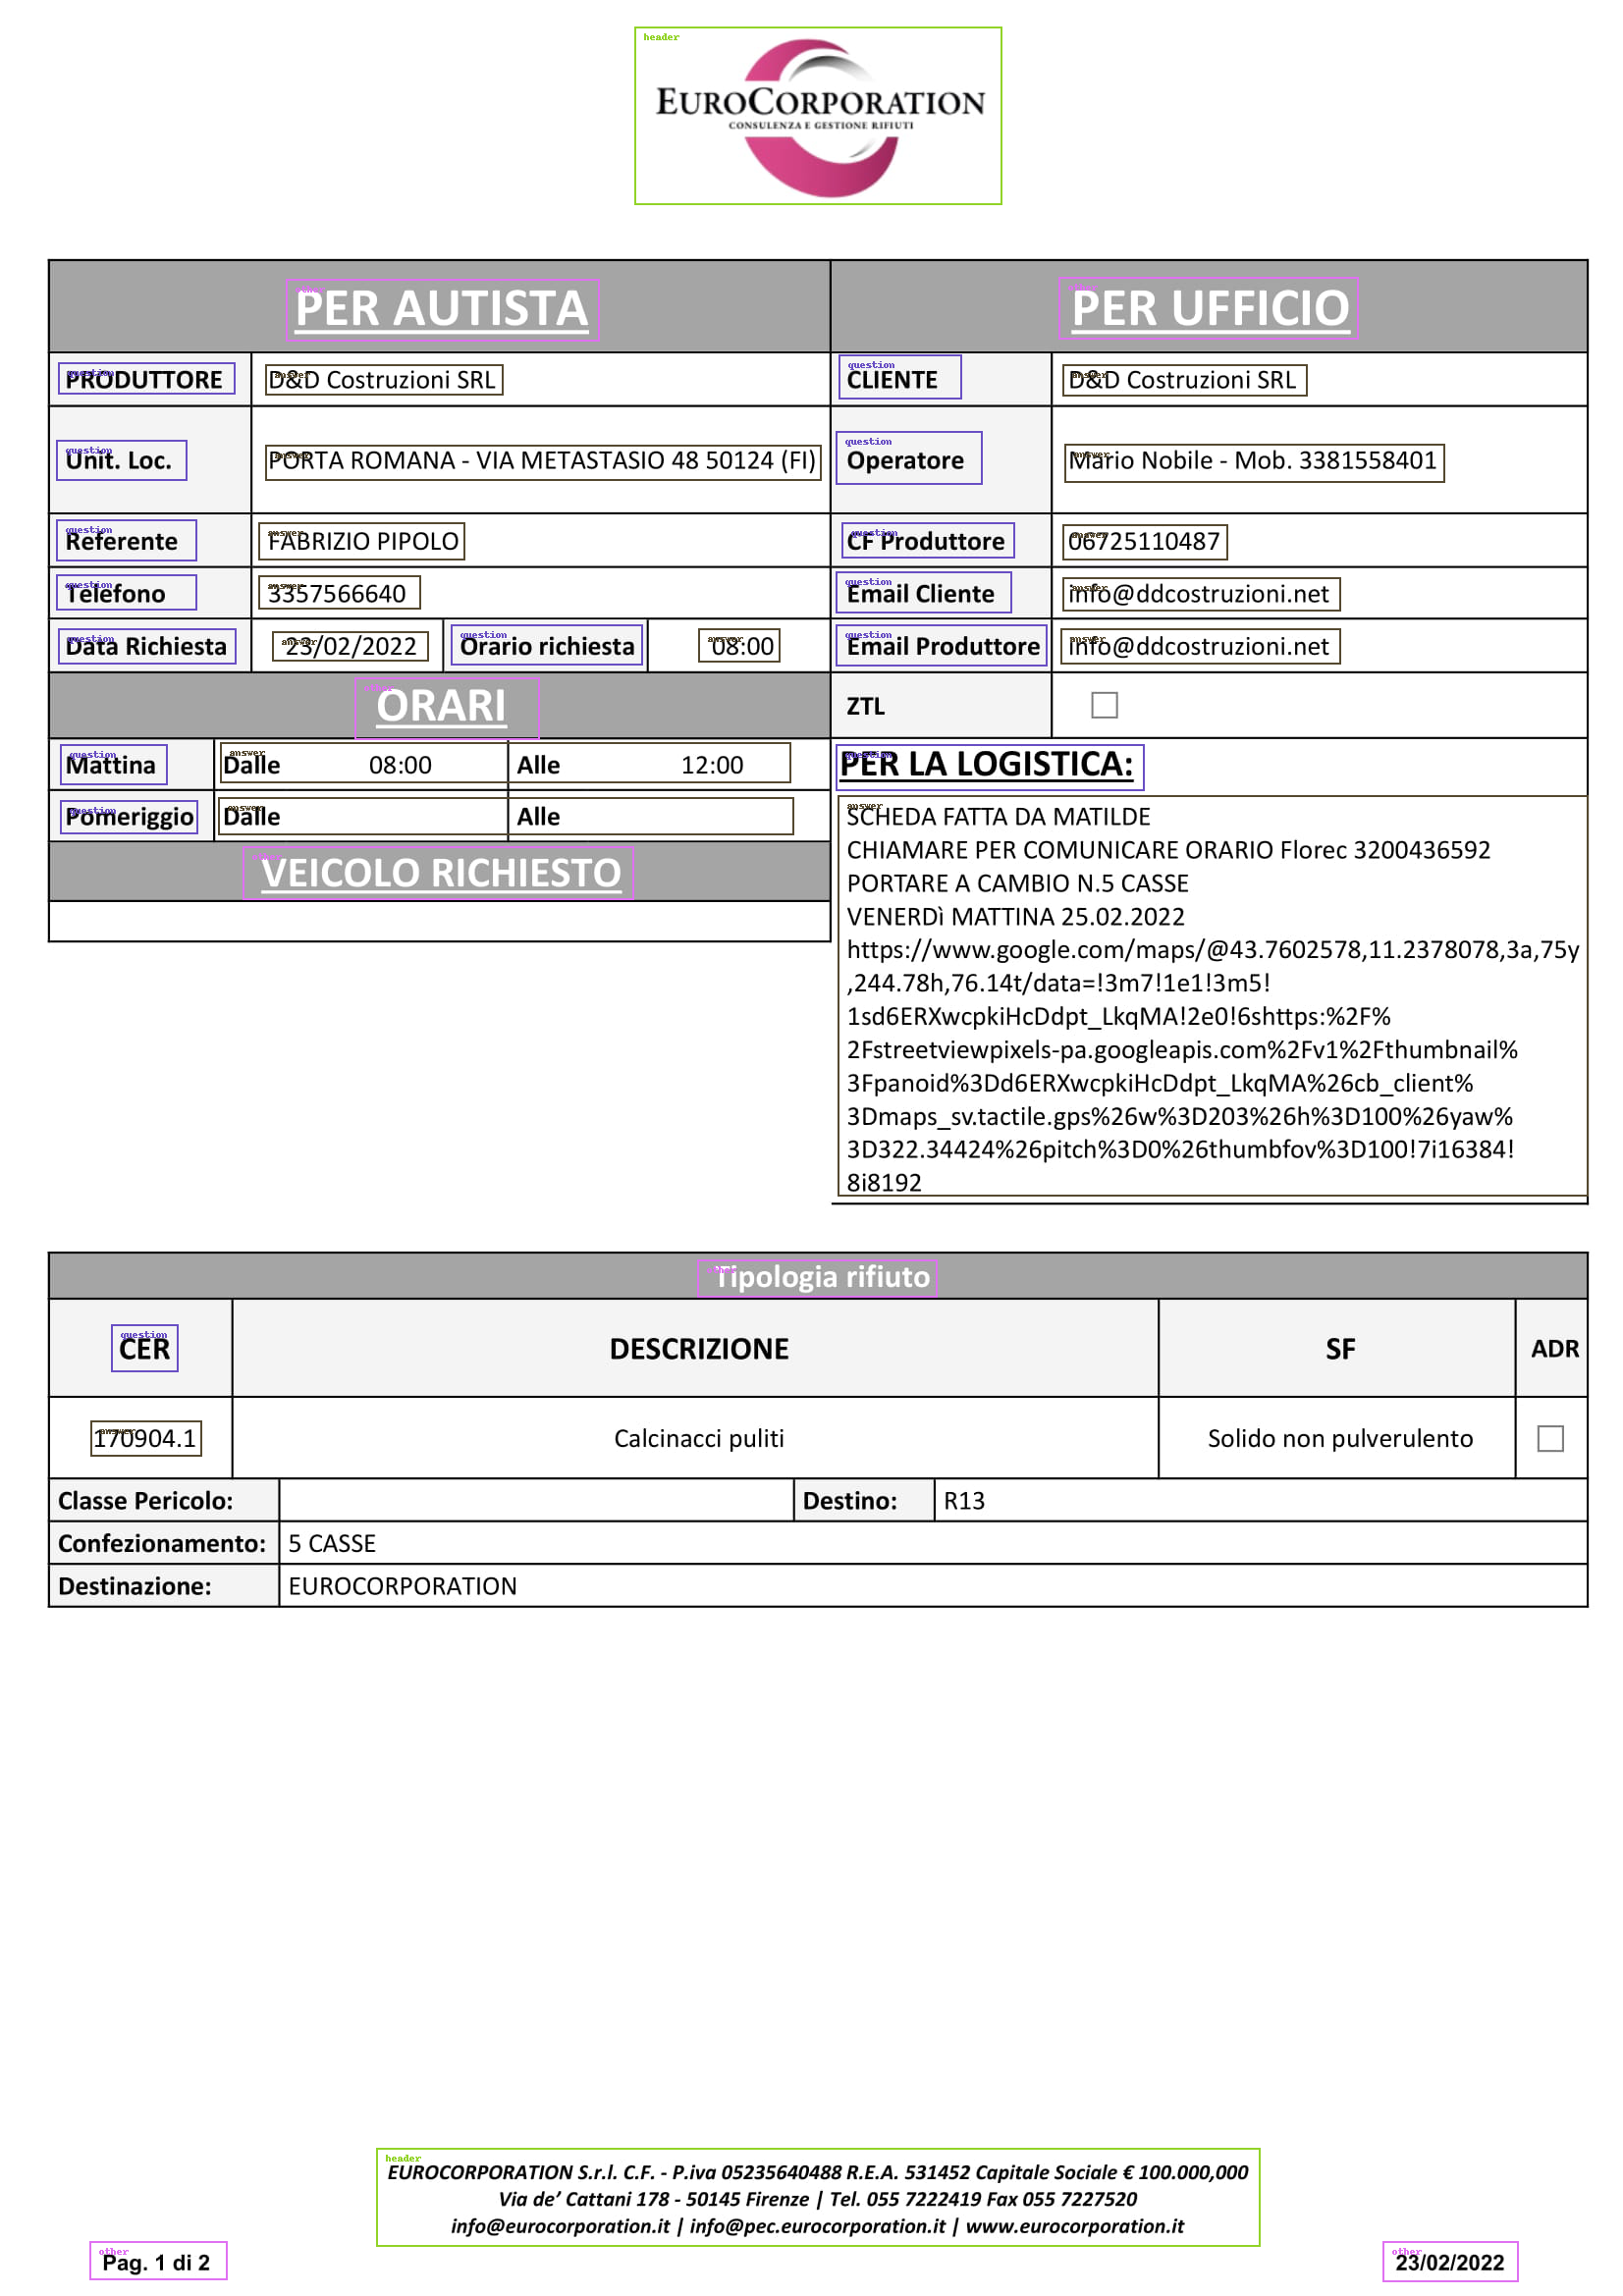

In [12]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

for annotation in data['valid_line']:
  label = annotation['category']
  words = annotation['words']
  for word in words:
    coordinates = word['quad']
    x1, y1 = coordinates['x1'], coordinates['y1']
    x3, y3 = coordinates['x3'], coordinates['y3']
    box = [x3, y1, x1, y3]
    draw.rectangle(box, outline=label2color[label], width=2)
    draw.text((box[0]+10, box[1]+5), label, fill=label2color[label], font=font)

image

# Generating the dataset

In [13]:
from tqdm.notebook import tqdm
from pathlib import Path
import os

def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

def generate_annotations(path: str):
  annotation_files = []
  image_files = []
  for js in tqdm(os.listdir(path)):
    image_files.append(Path(js).name.replace('.json', '.jpg'))
    with open(path + js) as f:
        annotation_files.append(json.load(f))
  
  words = []
  boxes = []
  labels = []
  images = []
  for js, im in tqdm(zip(annotation_files, image_files)):
      words_example = []
      boxes_example = []
      labels_example = []

      width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      # loop over OCR annotations
      for elem in js['valid_line']:
          for word in elem['words']:
              # get word
              txt = word['text']

              # get bounding box
              # important: each bounding box should be in (upper left, lower right) format
              # it took me some time to understand the upper left is (x1, y3)
              # and the lower right is (x3, y1)
              x1 = word['quad']['x1']
              y1 = word['quad']['y1']
              x3 = word['quad']['x3']
              y3 = word['quad']['y3']
              
              box = [x3, y1, x1, y3]
              box = normalize_bbox(box, width=width, height=height)

              # ADDED
              # skip empty word
              # if len(txt) < 1: 
              #   continue
              # if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
              #   continue
              # if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
              #   continue
              # ADDED

              words_example.append(txt)
              boxes_example.append(box) 
              labels_example.append(elem['category'])
      words.append(words_example) 
      boxes.append(boxes_example)
      labels.append(labels_example)
      images.append(im)
  
  return words, boxes, labels, images

Let's apply the function above for the training, validation and test set:

In [15]:
train_path = '/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/JSON/train/'
val_path = '/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/JSON/val/'
test_path = '/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/JSON/test/'

words_train, boxes_train, labels_train, images_train = generate_annotations(train_path)
words_val, boxes_val, labels_val, images_val = generate_annotations(val_path)
words_test, boxes_test, labels_test, images_test = generate_annotations(test_path)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [16]:
labels_train[0]

['header',
 'other',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'question',
 'answer',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'other',
 'other',
 'question',
 'answer',
 'question',
 'answer',
 'answer',
 'answer',
 'header',
 'other',
 'other']

In [17]:
words_train[0]

['&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL',
 'PER AUTISTA',
 'PER UFFICIO',
 'PRODUTTORE',
 'MONTECATINI DEKOR RESTAURI SOC. COOP.',
 'UnitLoc.',
 'TRAVERSAGNA - VIA LEOPARDI 1 51010 MASSA E COZZILE (PT)',
 'Referente',
 'FABRIZIO PIPOLO',
 'Telefono',
 '328/4446902',
 'Data Richiesta',
 '24/02/2022',
 'orario richiesta',
 '10:00',
 'CLIENTE',
 'MONTECATINI DEKOR RESTAURI SOC. COOP.',
 'Operatore',
 'Natalia Veracini - Mob. 3382652390',
 'CF Produttore',
 '01824330474',
 'Email Cliente',
 'montecatinicooperativa@gmail.com',
 'Email Produttore',
 'montecatinicooperativa@gmail.com',
 'ORARI',
 'Mattina',
 'Dalle 08:30 Alle 12:30',
 'Pomeriggio',
 'Dalle 14:30 Alle 17:00',
 'VEICOLO RICHIESTO',
 'Tipologia rifiuto',
 'CER',
 '170904.1',
 'PER LA LOGISTICA',
 'RITIRO SPOT. CHIAMARE PER COMUNICARE GIORNO E ORARIO. MEZZO IN OFFERTA: TUTTE LE SPONDE. PORTARE TRANSPALLET + NR 3 CASSE A CAMBIO. CONSEGNA NR 1 BB ONU CON DDT DI VENDITA. POI:https://www.google.it/maps/place/Via+G.+Leopar

In [18]:
boxes_train[0]

[[390, 11, 617, 88],
 [176, 121, 369, 148],
 [652, 120, 836, 147],
 [35, 157, 144, 171],
 [163, 159, 473, 171],
 [34, 191, 114, 209],
 [162, 184, 500, 216],
 [34, 226, 120, 244],
 [158, 227, 321, 243],
 [34, 250, 120, 265],
 [159, 250, 258, 265],
 [35, 273, 145, 289],
 [171, 274, 262, 288],
 [277, 271, 395, 289],
 [436, 273, 480, 287],
 [516, 154, 592, 173],
 [654, 156, 964, 173],
 [514, 187, 604, 210],
 [651, 188, 919, 213],
 [518, 227, 624, 242],
 [649, 224, 805, 241],
 [514, 248, 623, 266],
 [653, 248, 914, 265],
 [514, 271, 644, 289],
 [651, 272, 917, 289],
 [218, 294, 332, 321],
 [36, 324, 102, 341],
 [135, 323, 486, 340],
 [36, 348, 121, 362],
 [134, 347, 488, 363],
 [149, 368, 390, 391],
 [430, 532, 580, 549],
 [65, 559, 114, 585],
 [59, 604, 117, 618],
 [514, 324, 704, 344],
 [55, 696, 125, 709],
 [56, 878, 120, 892],
 [517, 346, 969, 507],
 [231, 935, 776, 978],
 [55, 976, 139, 992],
 [851, 976, 935, 993]]

# Saving

In [19]:
import pickle
with open('/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/pkl/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train, images_train], t)
with open('/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/pkl/val.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val, images_val], t)
with open('/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/pkl/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test, images_test], t)

In [20]:
import pandas as pd
train_df = pd.read_pickle('/content/drive/Shareddrives/Data Science Team folder-open/Sandeep Kumar Kushwaha/CORD dataset -Sandeep/pkl/train.pkl')
train_df

[[['&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL',
   'PER AUTISTA',
   'PER UFFICIO',
   'PRODUTTORE',
   'MONTECATINI DEKOR RESTAURI SOC. COOP.',
   'UnitLoc.',
   'TRAVERSAGNA - VIA LEOPARDI 1 51010 MASSA E COZZILE (PT)',
   'Referente',
   'FABRIZIO PIPOLO',
   'Telefono',
   '328/4446902',
   'Data Richiesta',
   '24/02/2022',
   'orario richiesta',
   '10:00',
   'CLIENTE',
   'MONTECATINI DEKOR RESTAURI SOC. COOP.',
   'Operatore',
   'Natalia Veracini - Mob. 3382652390',
   'CF Produttore',
   '01824330474',
   'Email Cliente',
   'montecatinicooperativa@gmail.com',
   'Email Produttore',
   'montecatinicooperativa@gmail.com',
   'ORARI',
   'Mattina',
   'Dalle 08:30 Alle 12:30',
   'Pomeriggio',
   'Dalle 14:30 Alle 17:00',
   'VEICOLO RICHIESTO',
   'Tipologia rifiuto',
   'CER',
   '170904.1',
   'PER LA LOGISTICA',
   'RITIRO SPOT. CHIAMARE PER COMUNICARE GIORNO E ORARIO. MEZZO IN OFFERTA: TUTTE LE SPONDE. PORTARE TRANSPALLET + NR 3 CASSE A CAMBIO. CONSEGNA NR 1 BB ON